In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,4)
%matplotlib inline

## shortage cleaning

In [2]:
# Load your dataset
# Replace 'your_dataset.csv' with the actual path or dataset name
claims = pd.read_excel('../data/Shortage_cleaned.xlsx',dtype={'PHASE':str})
print(claims.shape)

(15929, 43)


In [26]:
cols = [ 'UID', 'SHORTAGE', 'ORIGINAL_JOB_NUM', 'ORIGINAL_MFG_PLANT','PHASE', 'REASON','CUSTOMER_NAME','COMPANY','BRAND','Major Category','COMPLEXITY','OPL','Minor Category','RELEASE_DATE','GL_PERIOD','SQUAD','TEAM','BSR','SHORTAGE_COST_SPREAD','RELEASE_DATE_MONTH','GL_PERIOD_MONTH','RELEASE_DATE_YEAR','GL_PERIOD_YEAR']
claims.rename(columns={'Major Category1':'Major Category'},inplace=True)
claims.rename(columns={'Minor Category1':'Minor Category'},inplace=True)
claims.rename(columns={'SQUAD1':'SQUAD'},inplace=True)
claims.rename(columns={'TEAM1':'TEAM'},inplace=True)
claims.rename(columns={'CHECKER1':'CHECKER'},inplace=True)
claims.rename(columns={'DETAILER1':'DETAILER'},inplace=True)
claims['RELEASE_DATE'] = pd.to_datetime(claims['RELEASE_DATE'])
claims['GL_PERIOD'] = pd.to_datetime(claims['GL_PERIOD'])
claims['RELEASE_DATE_MONTH'] = claims['RELEASE_DATE'].dt.month
claims['GL_PERIOD_MONTH'] = claims['GL_PERIOD'].dt.month
claims['RELEASE_DATE_YEAR'] = claims['RELEASE_DATE'].dt.year
claims['GL_PERIOD_YEAR'] = claims['GL_PERIOD'].dt.year #.apply(lambda year: round(year))

df = claims[cols].copy()
df = df.dropna(subset=['SHORTAGE_COST_SPREAD'])
df =df.fillna('missing')

df = df.drop_duplicates()
print(df.shape)

(15876, 23)


In [4]:
df['logy_target'] = np.log(df['SHORTAGE_COST_SPREAD'] + 0.1)
target = 'logy_target'
print(df.shape)
upper_limit =df[target].quantile(0.975)
lower_limit = df[target].quantile(0.025)
print(lower_limit,upper_limit)
df = df[(df[target] >= lower_limit) & (df[target] <= upper_limit)]
print(df.shape)
df.head(1)

(15876, 24)
1.075002423028976 8.577081298942662
(14750, 24)


C:\Users\NishantJadhav\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,UID,SHORTAGE,ORIGINAL_JOB_NUM,ORIGINAL_MFG_PLANT,PHASE,REASON,CUSTOMER_NAME,COMPANY,BRAND,Major Category,COMPLEXITY,OPL,Minor Category,RELEASE_DATE,GL_PERIOD,SQUAD,TEAM,BSR,SHORTAGE_COST_SPREAD,RELEASE_DATE_MONTH,GL_PERIOD_MONTH,RELEASE_DATE_YEAR,GL_PERIOD_YEAR,logy_target
4,18S559050101CECOElizabethton17B89685,18S55905,17B89685,Elizabethton,0101,0415 - Error due to Engineering Scheduling,BORRELLI METAL BUILDINGS,CECO BUILDING SYSTEMS,CECO,Comm Ops,8.0,PENNAR,Eng. Scheduling,2022-02-22 00:00:00,2022-08-23,PENNAR,PENNAR,CARRIE SCHAFER,760.0,2.0,8.0,2022.0,2022.0,6.63345


<Axes: >

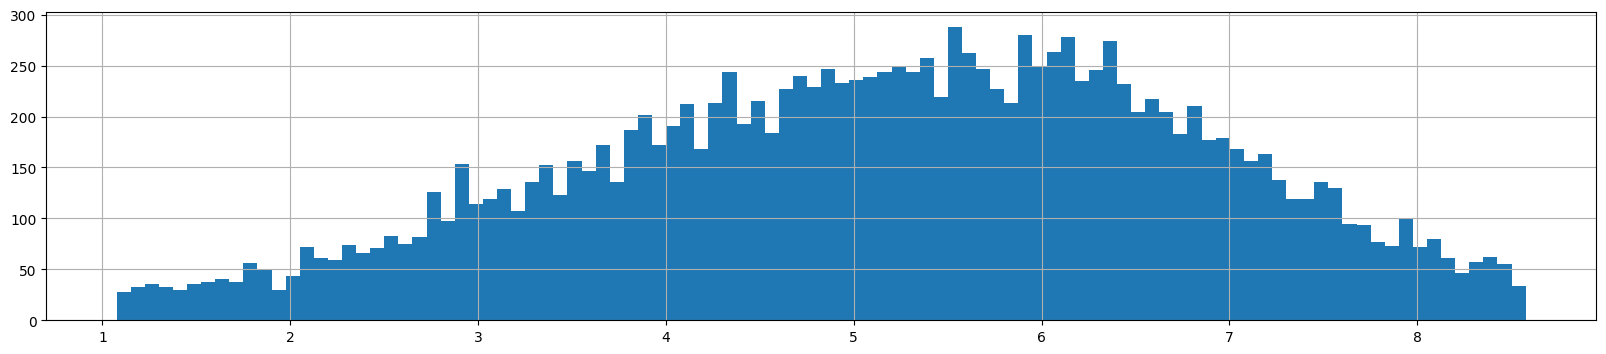

In [5]:
df[target].hist(bins=100)

In [6]:
df.head(1)

,UID,SHORTAGE,ORIGINAL_JOB_NUM,ORIGINAL_MFG_PLANT,PHASE,REASON,CUSTOMER_NAME,COMPANY,BRAND,Major Category,COMPLEXITY,OPL,Minor Category,RELEASE_DATE,GL_PERIOD,SQUAD,TEAM,BSR,SHORTAGE_COST_SPREAD,RELEASE_DATE_MONTH,GL_PERIOD_MONTH,RELEASE_DATE_YEAR,GL_PERIOD_YEAR,logy_target
4,18S559050101CECOElizabethton17B89685,18S55905,17B89685,Elizabethton,0101,0415 - Error due to Engineering Scheduling,BORRELLI METAL BUILDINGS,CECO BUILDING SYSTEMS,CECO,Comm Ops,8.0,PENNAR,Eng. Scheduling,2022-02-22 00:00:00,2022-08-23,PENNAR,PENNAR,CARRIE SCHAFER,760.0,2.0,8.0,2022.0,2022.0,6.63345


In [ ]:
# print(len(sure_steel))
# temp['Major Category'] = sure_steel['Major Category1'] +'_' + sure_steel['Major Category2'].fillna('missing')
# temp_df = temp['Major Category'].str.split("_").explode().reset_index()
# temp_df = temp_df[temp_df['Major Category']!='missing']
# sure_steel = sure_steel.reset_index()
# sure_steel =pd.merge(ss, temp_df, 'left',['index'])
# sure_steel.drop(['Major Category1','Major Category2','index'],axis=1,inplace=True)
# print(len(sure_steel))

In [ ]:
# print(len(sure_steel))
# temp['Minor Category'] = sure_steel['Minor Category1'] +'_' + sure_steel['Minor Category2'].fillna('missing')
# temp_df = temp['Minor Category'].str.split("_").explode().reset_index()
# temp_df = temp_df[temp_df['Minor Category']!='missing']
# sure_steel = sure_steel.reset_index()
# sure_steel =pd.merge(ss, temp_df, 'left',['index'])
# sure_steel.drop(['Minor Category1','Minor Category2','index'],axis=1,inplace=True)
# print(len(sure_steel))

## Merge Shipping data and QC

In [7]:
ship_shortage = pd.read_excel('../data/Shipping_Shortage_cleaned.xlsx')
ship_shortage.rename(columns={'SHORTAGE_TYPE':'REASON'},inplace=True)
ship_shortage.head(1)

,UID,SHORTAGE,ORIGINAL_JOB_NUM,PHASE,BRAND,ORIGINAL_MFG_PLANT,REASON,PIECEMARK,DESCRIPTION,INTERNAL_COMMENTS,MATERIAL_TYPE,DEPARTMENT_RESPONSIBLE,SALES_REGION_ID,SALES_DISTRICT_ID,CUSTOMER_ISSUE,SL_DRFT_TEAM_NAME,DATE_SHORTAGE_SHIPPED,DATE_CLAIM_RECEIVED,QUANTITY,FREIGHT_COST,COST_LABOR_MATERIAL,SHORT_SHIPPED COMPLETE
0,17S923490101CECOElizabethton17B76955,17S92349,17B76955,0101,CECO,Elizabethton,"0602 - Material Lost or Damaged in Transit, NC...",FB4A,Flg Brace 2 X 2 X .070 (Blocked),SHORT A TOTAL OF 12 SHIPPED SHORT,"COLD FORM (C's, Z's, HATS, BENT ANGLES, KIB's)",602,C400,C413,Project Notes:\n\n1. Match Frame Line Marking...,MEXICO,2021-01-07 18:00:00,2021-01-05 12:07:29,12,4.51,0.38,2021-01-07 18:00:00


In [8]:
ship_cols_sel = ['UID','SHORTAGE','REASON','ORIGINAL_JOB_NUM','PIECEMARK','SALES_REGION_ID','SALES_DISTRICT_ID','DEPARTMENT_RESPONSIBLE','QUANTITY']
ship = ship_shortage[ship_cols_sel].copy()
ship.head(1)

,UID,SHORTAGE,REASON,ORIGINAL_JOB_NUM,PIECEMARK,SALES_REGION_ID,SALES_DISTRICT_ID,DEPARTMENT_RESPONSIBLE,QUANTITY
0,17S923490101CECOElizabethton17B76955,17S92349,"0602 - Material Lost or Damaged in Transit, NC...",17B76955,FB4A,C400,C413,602,12


In [9]:
print(ship.shape)
ship = ship.drop_duplicates()
print(ship.shape)

(48266, 9)
(48266, 9)


In [10]:
overlap = ['SHORTAGE','ORIGINAL_JOB_NUM','REASON']

In [11]:
ship.head(1)

,UID,SHORTAGE,REASON,ORIGINAL_JOB_NUM,PIECEMARK,SALES_REGION_ID,SALES_DISTRICT_ID,DEPARTMENT_RESPONSIBLE,QUANTITY
0,17S923490101CECOElizabethton17B76955,17S92349,"0602 - Material Lost or Damaged in Transit, NC...",17B76955,FB4A,C400,C413,602,12


In [12]:
df2 = claims[['SHORTAGE','REASON','ORIGINAL_JOB_NUM']]
print(df2.shape)
df2 = df2.drop_duplicates()
df2.shape

(15929, 3)


(12512, 3)

In [13]:
ship2 = ship[['SHORTAGE','REASON','ORIGINAL_JOB_NUM','SALES_REGION_ID','SALES_DISTRICT_ID']]
ship2 = ship2.drop_duplicates()
print(ship2.shape)
ship2.head()

(21558, 5)


,SHORTAGE,REASON,ORIGINAL_JOB_NUM,SALES_REGION_ID,SALES_DISTRICT_ID
0,17S92349,"0602 - Material Lost or Damaged in Transit, NC...",17B76955,C400,C413
3,17S90763,0807 - B & S Accessories,17B78021,S800,S801
5,17S90763,0403 - Parts Billed Insufficient Quantity,17B78021,S800,S801
6,17S93322,"0602 - Material Lost or Damaged in Transit, NC...",17B65461,C500,C508
7,18S21502,0406 - Material Billed or Detailed to Incorrec...,17B71309,S400,S408


In [14]:
t1 = claims.groupby(['SHORTAGE','REASON','ORIGINAL_JOB_NUM'])['SHORTAGE_COST_SPREAD'].nunique().sort_values().reset_index()

In [15]:
t1[t1.SHORTAGE == '19S42514']

,SHORTAGE,REASON,ORIGINAL_JOB_NUM,SHORTAGE_COST_SPREAD
11698,19S42514,1102 - Allowance by V. P. Sales,18B32231,2


In [16]:
merged2 = pd.merge(df2,ship2,'left',on=overlap)
merged2.shape

(12512, 5)

In [17]:
df[df.SHORTAGE == '19S42514']

,UID,SHORTAGE,ORIGINAL_JOB_NUM,ORIGINAL_MFG_PLANT,PHASE,REASON,CUSTOMER_NAME,COMPANY,BRAND,Major Category,COMPLEXITY,OPL,Minor Category,RELEASE_DATE,GL_PERIOD,SQUAD,TEAM,BSR,SHORTAGE_COST_SPREAD,RELEASE_DATE_MONTH,GL_PERIOD_MONTH,RELEASE_DATE_YEAR,GL_PERIOD_YEAR,logy_target
14154,19S425140101STARMonticello18B32231,19S42514,18B32231,Monticello,0101,1102 - Allowance by V. P. Sales,FURNITURE ROW USA LLC DENVER,STAR BUILDING SYSTEMS,STAR,Sales,10.0,NA Contractor,Goodwill,2022-05-06 00:00:00,2023-11-23,H&H,H&H,MIKE DRAGER,2328.46,5.0,11.0,2022.0,2023.0,7.753005


In [18]:
text_based = pd.read_csv('../data/all_shortage_notes_damaged_component_gpt4.csv')

In [19]:
text_based.shape

(12472, 6)

In [20]:
merged2['ID_JOB'] = merged2['SHORTAGE'] + merged2['ORIGINAL_JOB_NUM'] + merged2['REASON']
merged2.shape

(12512, 6)

In [21]:
merged3 = pd.merge(merged2,text_based.loc[:, text_based.columns != 'REASON'],'left',on=['ID_JOB'])
merged3 = merged3.fillna('missing')
merged3['Claim Component'] = merged3['Claim Component'].str.strip('[]')
merged3.shape

(12512, 10)

In [22]:
merged4 = pd.merge(df,merged3,'left',on=['SHORTAGE','REASON','ORIGINAL_JOB_NUM'])
merged4.shape

(14750, 31)

In [24]:
pf = ship[['SHORTAGE','REASON','ORIGINAL_JOB_NUM','PIECEMARK','QUANTITY']]
print(pf.shape)
pf = pf.drop_duplicates()
print(pf.shape)

(48266, 5)
(45505, 5)


In [25]:
merged3 = pd.merge(merged2,pf,'left',overlap)
print(merged3.shape)
merged3 = merged3.drop_duplicates()
merged3.shape

(26541, 8)


(26541, 8)

In [ ]:
merged3.to_excel('../data/ship_piecemark_region_district.xlsx',index=False)

In [ ]:
tp = merged3.groupby(['PIECEMARK'])['QUANTITY'].sum().sort_values(ascending=False).reset_index()[:5]

In [ ]:
px.bar(tp,'PIECEMARK','QUANTITY')

In [ ]:
df3 = ship.groupby(['SHORTAGE','ORIGINAL_JOB_NUM','REASON','PIECEMARK'])['QUANTITY'].sum().reset_index()
df3.shape

In [ ]:
df4 = ship[['SHORTAGE','REASON','ORIGINAL_JOB_NUM','SALES_REGION_ID','SALES_DISTRICT_ID']].drop_duplicates()
df4.shape

In [ ]:
ship.groupby(['SHORTAGE','REASON','ORIGINAL_JOB_NUM'])['SALES_DISTRICT_ID'].nunique().sort_values()

In [ ]:
df3.shape

In [ ]:
ship[(ship.SHORTAGE == '18S55905') & (ship.ORIGINAL_JOB_NUM == '17B89685') & (ship.PIECEMARK == '1 LOT-0400') ]

In [ ]:
merged3.groupby('PIECEMARK')['QUANTITY'].sum().sort_values(ascending=False)[:10].reset_index()

In [ ]:
print(df.shape)
merged = pd.merge(df,ship,'left',overlap)
print(merged.shape)

In [ ]:
merged['PIECEMARK'].fillna('missing',inplace=True)
merged['SALES_REGION_ID'].fillna('missing',inplace=True)
merged['SALES_DISTRICT_ID'].fillna('missing',inplace=True)
merged['DEPARTMENT_RESPONSIBLE'].fillna('missing',inplace=True)

In [ ]:
# merged.to_excel('../data/Shortage_regression.xlsx',index=False)

In [ ]:
table = pd.DataFrame(columns=['Dimension','Value','%Cost','% EffCost']) 

In [ ]:
new  = pd.DataFrame({'Dimension':[1],'Value':[2],'%Cost':[3],'% EffCost':[4]})

In [ ]:
new

In [ ]:
pd.concat([table,new])

## Preprocessing and Feature Engineering

In [ ]:
data = merged.copy()
print(data.shape)
data.head(1)

In [ ]:
threshold = 0  # Adjust as needed
# data['RELEASE_DATE'] = pd.to_datetime(data['RELEASE_DATE'])
# data['RELEASE_DATE_MONTH'] = data['RELEASE_DATE'].dt.month
# data['RELEASE_DATE_YEAR'] = data['RELEASE_DATE'].dt.year
# data['RELEASE_DATE_MONTH'] =data['RELEASE_DATE_MONTH'].fillna('missing')


# data['ORIGINAL_JOB_AMOUNT'] = data['ORIGINAL_JOB_AMOUNT'].fillna(data['ORIGINAL_JOB_AMOUNT'].mean()) 
# data['COMPLEXITY'].fillna(-1,inplace=True)

# data['ORIGINAL_JOB_AMOUNT'] = data['ORIGINAL_JOB_AMOUNT'].apply(lambda x: round(x))
# data['GL_PERIOD_MONTH'] = data['GL_PERIOD'].dt.month
# data['GL_PERIOD_YEAR'] = data['GL_PERIOD'].dt.year
# infrequent_categories = data['CUSTOMER_NAME'].value_counts()[data['CUSTOMER_NAME'].value_counts(normalize=True) < threshold].index
# data['CUSTOMER_NAME'] = data['CUSTOMER_NAME'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['REASON'].value_counts()[data['REASON'].value_counts(normalize=True) < threshold].index
# data['REASON'] = data['REASON'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['ORIGINAL_MFG_PLANT'].value_counts()[data['ORIGINAL_MFG_PLANT'].value_counts(normalize=True) < threshold].index
# data['ORIGINAL_MFG_PLANT'] = data['ORIGINAL_MFG_PLANT'].replace(infrequent_categories, 'OTHER')


# infrequent_categories = data['SQUAD1'].value_counts()[data['SQUAD1'].value_counts(normalize=True) < threshold].index
# data['SQUAD1'] = data['SQUAD1'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['TEAM1'].value_counts()[data['TEAM1'].value_counts(normalize=True) < threshold].index
# data['TEAM1'] = data['TEAM1'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['CHECKER1'].value_counts()[data['CHECKER1'].value_counts(normalize=True) < threshold].index
# data['CHECKER1'] = data['CHECKER1'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['DETAILER1'].value_counts()[data['DETAILER1'].value_counts(normalize=True) < threshold].index
# data['DETAILER1'] = data['DETAILER1'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['AUTHORIZED_BY'].value_counts()[data['AUTHORIZED_BY'].value_counts(normalize=True) < threshold].index
# data['AUTHORIZED_BY'] = data['AUTHORIZED_BY'].replace(infrequent_categories, 'OTHER')

# infrequent_categories = data['Major Category1'].value_counts()[data['Major Category1'].value_counts(normalize=True) < threshold].index
# data['Major Category1'] = data['Major Category1'].replace(infrequent_categories, 'OTHER')
# infrequent_categories = data['Minor Category1'].value_counts()[data['Minor Category1'].value_counts(normalize=True) < threshold].index
# data['Minor Category1'] = data['Minor Category1'].replace(infrequent_categories, 'OTHER')

In [ ]:
data.head(1)

## Input Prep

Level 1 : Company , Phase , Brand, Major Category, Complexity, OPL , Org Mfg Plant  
Level 2 : Minor Category, GL Month, Release Month, Org Mfg Plant, Sales Region Id, SQUAD, TEAM, REASON, BSR, CHECKER, DETAILER   
Level 3 : DEPARTMENT_RESPONSIBLE, SALES_DISTRICT_ID, QUANTITY, PIECEMARK

In [ ]:
data.head(1)

In [ ]:
print(data.shape)
sliced_data =  data[(data['Major Category']=='Sales')]
# sliced_data = sliced_data[sliced_data['REASON']=='1102 - Allowance by V. P. Sales'] # select data slice
print(sliced_data.shape)

In [ ]:
sliced_data.head(1)

In [ ]:
columns1 = ['COMPANY','PHASE','BRAND','Major Category','COMPLEXITY','OPL','ORIGINAL_MFG_PLANT', target]
columns2 = ['Minor Category','GL_PERIOD_MONTH','RELEASE_DATE_MONTH', 'SALES_REGION_ID','SQUAD','TEAM','REASON','BSR'] #,'CHECKER','DETAILER'
columns3 = ['SALES_DISTRICT_ID', 'PIECEMARK','CUSTOMER_NAME'] #,'QUANTITY'
columns = columns1  + columns2  #+ columns3
# columns.remove("Major Category")
# columns.remove("ORIGINAL_MFG_PLANT")
# columns.remove("BSR")

X = sliced_data[columns]
X = X.dropna(subset=[target])
X = X.drop_duplicates()
print(X.shape)
X.head(2)

## Train test split

In [ ]:
X =pd.get_dummies(X)
y = X[target]
X = X.drop(target, axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
X_train.head(2)

## Model Training

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

In [ ]:
%%time
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_feature_importance = gb_model.feature_importances_

In [ ]:
%%time
cb_model = CatBoostRegressor(iterations=100,  # Adjust the number of iterations
                          depth=5,  # Adjust the depth of the trees
                          learning_rate=0.1,  # Adjust the learning rate
                          loss_function='RMSE',  # Use RMSE as the loss function for regression
                          random_seed=42)

cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

In [ ]:
%%time
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(max_depth=None,)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

## Prediction and feature importance

In [ ]:
for model in [lr_model,gb_model,cb_model,rf_model]:
    y_pred = model.predict(X_train) 
    r2 = r2_score(y_train, y_pred)
    print(f"{str(model)} ----> {r2}")


In [ ]:
# model = lr_model # select model
# model = gb_model # select model
# model = cb_model # select model
model = rf_model # select model

In [ ]:
y_pred = model.predict(X_test) # Test

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2} -- explaining {round(r2*100,2)}% of variance in the data')

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df['Column'] = importance_df['Feature'].str.split("_").apply(lambda x: '_'.join(x[:-1]) if len(x)>1 else x[0] )
importance_df['Value'] = importance_df['Feature'].str.split("_").apply(lambda x: x[-1] if len(x) > 1 else 'none')
feature_importance_df = importance_df.groupby('Column')['Importance'].sum().sort_values(ascending=False).reset_index()
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df['Importance'] = feature_importance_df['Importance'].apply(lambda x: "{:f}".format(x))
feature_importance_df['Importance'] = feature_importance_df['Importance'].apply(lambda x: float(x))
top_features = feature_importance_df.head(5)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Column'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
px.bar(top_features,'Importance','Column',orientation='h',color='Importance')

## EDA

In [34]:
eda_slice = claims.copy()

In [64]:
group_level= 'GL_PERIOD'
agg = eda_slice.drop_duplicates([group_level,'SHORTAGE','ORIGINAL_JOB_NUM','REASON','SHORTAGE_COST_SPREAD'])
agg = agg.groupby([group_level])['SHORTAGE_COST_SPREAD'].sum().reset_index()
agg = agg.set_index(group_level)
agg.head()

,SHORTAGE_COST_SPREAD
GL_PERIOD,
2022-01-23,407034.31
2022-02-23,435049.48
2022-03-23,490933.37
2022-04-23,406622.33
2022-05-23,424355.92


In [70]:
agg.head(3)['SHORTAGE_COST_SPREAD'].sum()

1333017.1600000001

In [71]:
agg2 =  agg.resample('Q').sum().reset_index()
agg2

,GL_PERIOD,SHORTAGE_COST_SPREAD
0,2022-03-31,1333017.16
1,2022-06-30,1231346.75
2,2022-09-30,1740097.24
3,2022-12-31,1460931.17
4,2023-03-31,1458265.24
5,2023-06-30,2183811.63
6,2023-09-30,1473361.88
7,2023-12-31,2064227.42


In [78]:
agg2['GL_PERIOD'].tolist()

[Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-06-30 00:00:00'),
 Timestamp('2022-09-30 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 Timestamp('2023-09-30 00:00:00'),
 Timestamp('2023-12-31 00:00:00')]

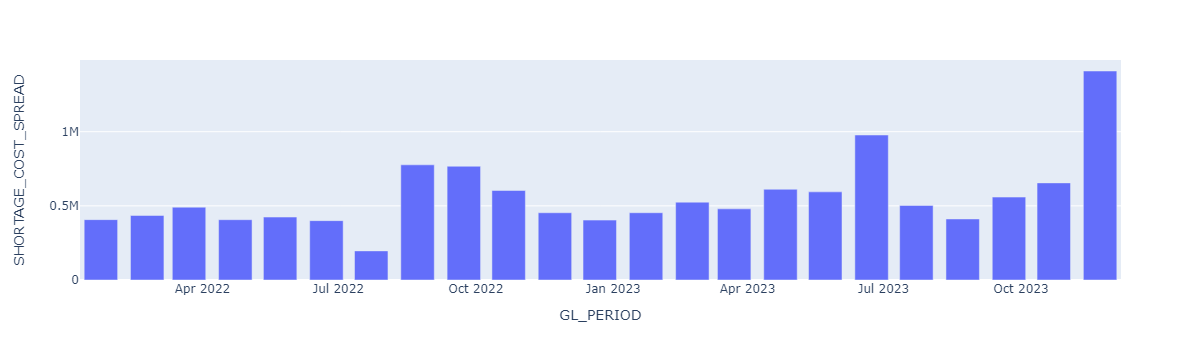

In [58]:
px.bar(agg.reset_index(),group_level,'SHORTAGE_COST_SPREAD')

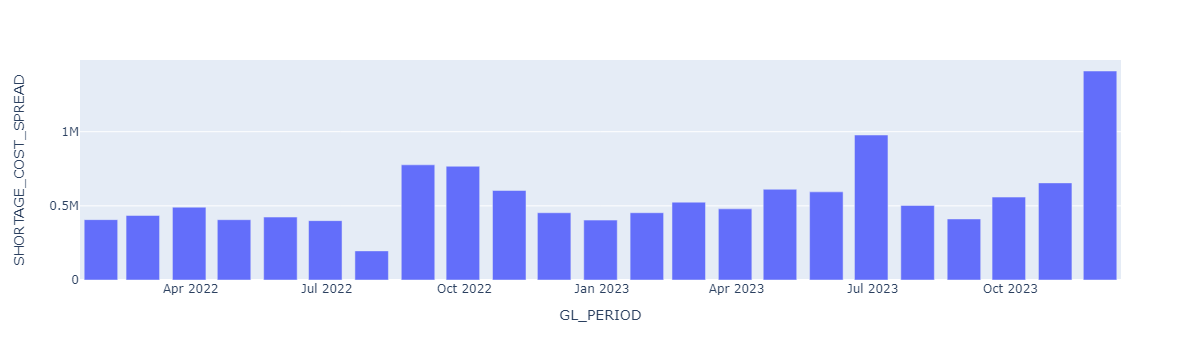

In [61]:
px.bar(agg.resample('').sum().reset_index(),group_level,'SHORTAGE_COST_SPREAD')

In [30]:
# eda_slice.to_excel('../data/Shortage_Graphs.xlsx',index=False)

In [31]:
eda_slice[eda_slice['Major Category']=='Sales'].shape

(5241, 47)

In [32]:
# merged.head(1)

In [ ]:
# eda_slice = eda_slice[eda_slice['Major Category'] =='Manufacturing']
# eda_slice = eda_slice[eda_slice['COMPLEXITY'] ==7.0]
# eda_slice = eda_slice[eda_slice['SALES_REGION_ID'] =='C300'] 

In [ ]:
cat_spread['SHORTAGE_COST_SPREAD'].apply(lambda x: '${:.2f}M'.format(x / 1e6))

In [ ]:
cat_spread['SHORTAGE_COST_SPREAD'].apply(lambda x: "$"+str(round(x)))

In [ ]:
cat_spread[cat_spread['Major Category']=='Sales']

In [ ]:
group_level = 'Major Category'

In [ ]:
record = cat_spread[cat_spread['Major Category']=='Sales']

In [ ]:
record[group_level].iloc[0]

(14531, 47)


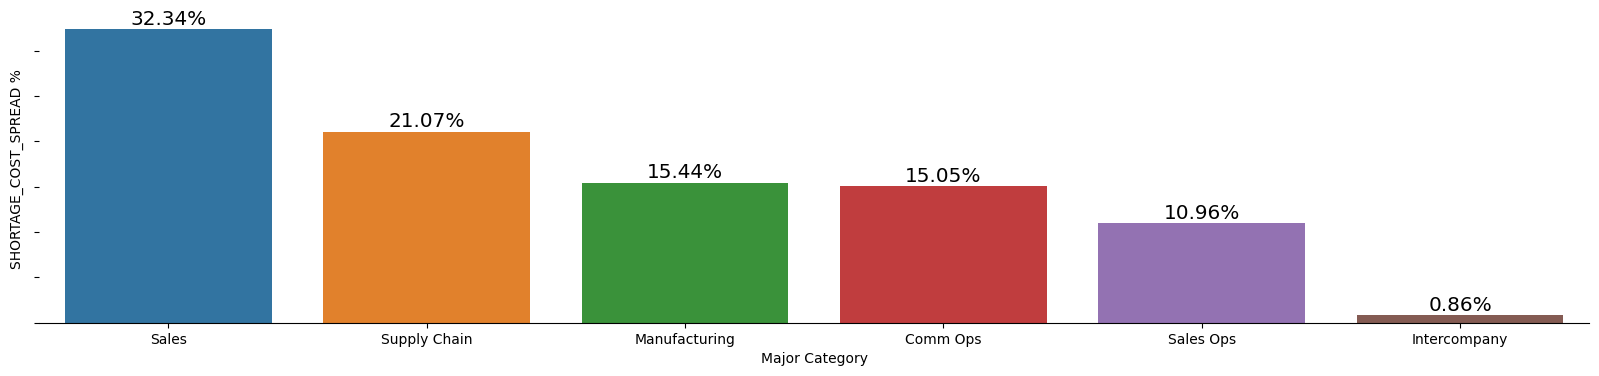

In [33]:
dimension = 'Major Category'
cat_spread = eda_slice.drop_duplicates([dimension,'SHORTAGE','SHORTAGE_COST_SPREAD']) # review later
print(cat_spread.shape)
cat_spread =  cat_spread.groupby(dimension)['SHORTAGE_COST_SPREAD'].sum().sort_values(ascending=False).reset_index()
cat_spread['SHORTAGE_COST_SPREAD %'] = cat_spread['SHORTAGE_COST_SPREAD']/cat_spread['SHORTAGE_COST_SPREAD'].sum()*100
cat_spread = cat_spread[cat_spread[dimension]!='missing']
cat_spread[dimension] = cat_spread[dimension].astype(str)
# cat_spread = cat_spread.iloc[:5]
sns.barplot(x=dimension,y='SHORTAGE_COST_SPREAD %',data=cat_spread)
sns.despine(left=True,right=True)
ax = sns.barplot(x=dimension,y='SHORTAGE_COST_SPREAD %',data=cat_spread)
ax.set_yticklabels([])
for i, v in enumerate(cat_spread['SHORTAGE_COST_SPREAD %']):
    ax.text(i, v + 0.5, str(round(v,2))+"%", ha='center',fontsize ='x-large') 

In [ ]:
111.2.formatt('$%{text:,.2s}')

In [ ]:
cat_spread

In [ ]:
print(eda_slice.shape)
cat_count = eda_slice.drop_duplicates(['UID','REASON'])
print(cat_count.shape)
cat_count =  cat_count.groupby(dimension)['UID'].count().sort_values(ascending=False).reset_index() 
cat_count = cat_count[cat_count[dimension]!='missing']
cat_count[dimension] = cat_count[dimension].astype(str)
cat_count = cat_count.iloc[:15]
cat_count

In [ ]:
merged['SHORTAGE_COST_SPREAD']

In [ ]:
df1 = merged[['SHORTAGE','ORIGINAL_JOB_NUM', 'REASON', 'PIECEMARK','SHORTAGE_COST_SPREAD']]

In [ ]:
df1.groupby(['SHORTAGE','ORIGINAL_JOB_NUM', 'REASON', 'PIECEMARK'])['SHORTAGE_COST_SPREAD'].nunique().sort_values()

In [ ]:
claims['SHORTAGE_COST_SPREAD'].describe()

In [ ]:
claims['CUSTOMER_NAME'].nunique()